# Privacy Attacks

In [1]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

In [2]:
torch.set_num_threads(1)
cwd = os.path.join(os.getcwd(), '..', '..')

p_indian_list = [0.005, 0.01, 0.05,
                 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                 0.95, 0.99, 0.995]
out_rate = 1000

## Attack sketches

In [3]:
all_cores_dir = os.path.join(cwd, 'results', '6_privacy', 'fffc_tiny', 'cores')

acc_diffs_cores = []
for p in p_indian_list:
    p_acc_diff = []
    for idx in range(10):
        cores_dir = os.path.join(all_cores_dir, str(p), str(idx))
        files_lst = os.listdir(cores_dir)
        for f in files_lst:
            test_acc = float(f.split('_')[1])
            sketch_acc = float(f.split('_')[2][:-3])
            p_acc_diff.append(sketch_acc - test_acc)
        
    p_acc_diff = torch.Tensor(p_acc_diff)
    acc_diffs_cores.append((p, (p_acc_diff.mean(), p_acc_diff.std())))

acc_diffs_cores = dict(acc_diffs_cores)
acc_diffs_cores

{0.005: (tensor(0.0107), tensor(0.0345)),
 0.01: (tensor(0.0082), tensor(0.0336)),
 0.05: (tensor(0.0062), tensor(0.0370)),
 0.1: (tensor(0.0065), tensor(0.0376)),
 0.2: (tensor(0.0119), tensor(0.0358)),
 0.3: (tensor(0.0120), tensor(0.0385)),
 0.4: (tensor(0.0014), tensor(0.0345)),
 0.5: (tensor(0.0088), tensor(0.0351)),
 0.6: (tensor(0.0042), tensor(0.0374)),
 0.7: (tensor(0.0027), tensor(0.0358)),
 0.8: (tensor(0.0116), tensor(0.0347)),
 0.9: (tensor(0.0002), tensor(0.0339)),
 0.95: (tensor(0.0094), tensor(0.0315)),
 0.99: (tensor(0.0002), tensor(0.0363)),
 0.995: (tensor(0.0090), tensor(0.0317))}

In [4]:
all_recores_dir = os.path.join(cwd, 'results', '6_privacy', 'fffc_tiny', 'recores')

acc_diffs_recores = []
for p in p_indian_list:
    p_acc_diff = []
    for idx in range(10):
        recores_dir = os.path.join(all_recores_dir, str(p), str(idx))
        files_lst = os.listdir(recores_dir)
        for f in files_lst:
            test_acc = float(f.split('_')[1])
            sketch_acc = float(f.split('_')[2][:-3])
            p_acc_diff.append(sketch_acc - test_acc)
        
    p_acc_diff = torch.Tensor(p_acc_diff)
    acc_diffs_recores.append((p, (p_acc_diff.mean(), p_acc_diff.std())))

acc_diffs_recores = dict(acc_diffs_recores)
acc_diffs_recores

{0.005: (tensor(0.0063), tensor(0.0315)),
 0.01: (tensor(0.0068), tensor(0.0316)),
 0.05: (tensor(0.0031), tensor(0.0347)),
 0.1: (tensor(0.0041), tensor(0.0318)),
 0.2: (tensor(0.0077), tensor(0.0315)),
 0.3: (tensor(0.0055), tensor(0.0337)),
 0.4: (tensor(-0.0009), tensor(0.0321)),
 0.5: (tensor(0.0058), tensor(0.0310)),
 0.6: (tensor(0.0020), tensor(0.0332)),
 0.7: (tensor(0.0014), tensor(0.0309)),
 0.8: (tensor(0.0052), tensor(0.0300)),
 0.9: (tensor(0.0008), tensor(0.0282)),
 0.95: (tensor(0.0048), tensor(0.0294)),
 0.99: (tensor(8.0000e-05), tensor(0.0329)),
 0.995: (tensor(0.0041), tensor(0.0278))}

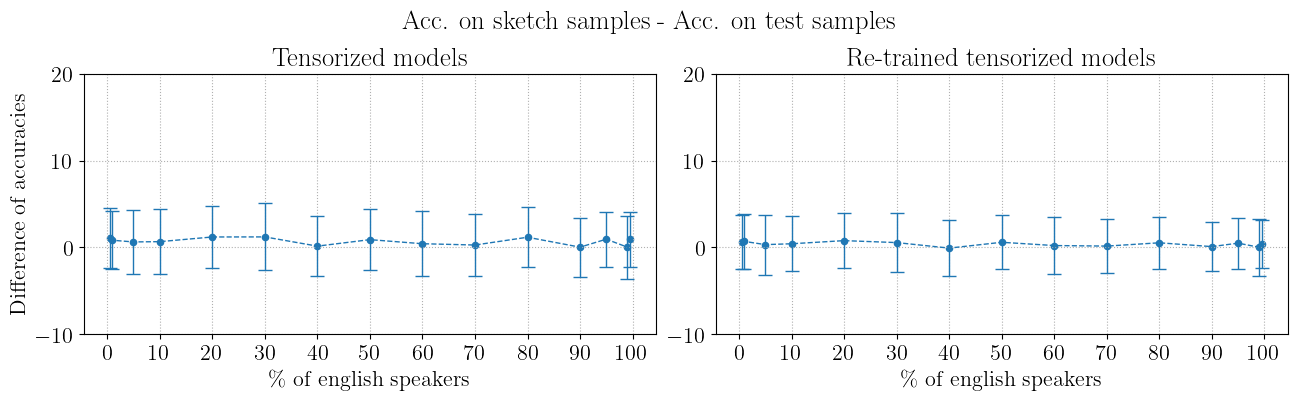

In [5]:
# plt.rc('font', family='serif', size=15)
plt.rc('font', family='serif', serif='Computer Modern', size=16)
plt.rc('text', usetex=True)

colormap = plt.get_cmap("tab10")

fig, axs = plt.subplots(1, 2, figsize=(13, 4))
ps = [p * 100 for p in p_indian_list]

# Cores
# -----
means = torch.stack(list(map(lambda t: t[0] * 100,
                             acc_diffs_cores.values()))).tolist()
stds = torch.stack(list(map(lambda t: t[1] * 100,
                            acc_diffs_cores.values()))).tolist()

axs[0].errorbar(x=ps, y=means, yerr=stds, capsize=5.,
                linestyle='--', linewidth=1., color='tab:blue')
axs[0].scatter(x=ps, y=means, marker='o', s=20., color='tab:blue')

# Set axes
axs[0].set_xlabel('\% of english speakers')
axs[0].set_ylabel('Difference of accuracies')
axs[0].set_title('Tensorized models')

axs[0].set_ylim(-10, 20)
axs[0].yaxis.grid(linestyle=':')
axs[0].xaxis.grid(linestyle=':')

axs[0].set_xticks(torch.arange(100*0., 100*1.05, 10))

# Recores
# -------
means = torch.stack(list(map(lambda t: t[0] * 100,
                             acc_diffs_recores.values()))).tolist()
stds = torch.stack(list(map(lambda t: t[1] * 100,
                            acc_diffs_recores.values()))).tolist()

axs[1].errorbar(x=ps, y=means, yerr=stds, capsize=5.,
                linestyle='--', linewidth=1., color='tab:blue')
axs[1].scatter(x=ps, y=means, marker='o', s=20., color='tab:blue')

# Set axes
axs[1].set_xlabel('\% of english speakers')
axs[1].set_title('Re-trained tensorized models')

axs[1].set_ylim(-10, 20)
axs[1].yaxis.grid(linestyle=':')
axs[1].xaxis.grid(linestyle=':')

axs[1].set_xticks(torch.arange(100*0., 100*1.05, 10))


fig.suptitle('Acc. on sketch samples - Acc. on test samples')

plt.tight_layout(pad=0.5)

results_dir = os.path.join(cwd, 'results', '6_privacy', 'fffc_tiny', 'attacks')
plt.savefig(os.path.join(results_dir, 'attack_sketches.pdf'), bbox_inches='tight')

plt.show()

## NNs and MPSs accuracies

In [20]:
combs = [(0, 0), (0, 1), (1, 0), (1, 1)]

accs_by_comb_nn = []
for l, k in combs:
    accs = {}
    for p in p_indian_list:
        aux_acc = torch.load(
            os.path.join(cwd, 'results', '6_privacy', 'fffc_tiny',
                         'attacks', 'acc_by_class', 'nn', str(p), f'{l}_{k}.pt'),
            weights_only=False)
        accs[p] = aux_acc
    accs_by_comb_nn.append(accs)

mean_nn = {}
for p in p_indian_list:
    s = 0
    for i in range(4):
        s += accs_by_comb_nn[i][p][0]
    mean_nn[p] = s / 4

In [21]:
combs = [(0, 0), (0, 1), (1, 0), (1, 1)]

accs_by_comb_mps = []
for l, k in combs:
    accs = {}
    for p in p_indian_list:
        aux_acc = torch.load(
            os.path.join(cwd, 'results', '6_privacy', 'fffc_tiny',
                         'attacks', 'acc_by_class', 'recores', str(p), f'{l}_{k}.pt'),
            weights_only=False)
        accs[p] = aux_acc
    accs_by_comb_mps.append(accs)

mean_mps = {}
for p in p_indian_list:
    s = 0
    for i in range(4):
        s += accs_by_comb_mps[i][p][0]
    mean_mps[p] = s / 4

In [22]:
combs = [(0, 0), (0, 1), (1, 0), (1, 1)]

accs_by_comb_priv_mps = []
for l, k in combs:
    accs = {}
    for p in p_indian_list:
        aux_acc = torch.load(
            os.path.join(cwd, 'results', '6_privacy', 'fffc_tiny',
                         'attacks', 'acc_by_class', 'priv_recores', str(p), f'{l}_{k}.pt'),
            weights_only=False)
        accs[p] = aux_acc
    accs_by_comb_priv_mps.append(accs)

mean_priv_mps = {}
for p in p_indian_list:
    s = 0
    for i in range(4):
        s += accs_by_comb_priv_mps[i][p][0]
    mean_priv_mps[p] = s / 4

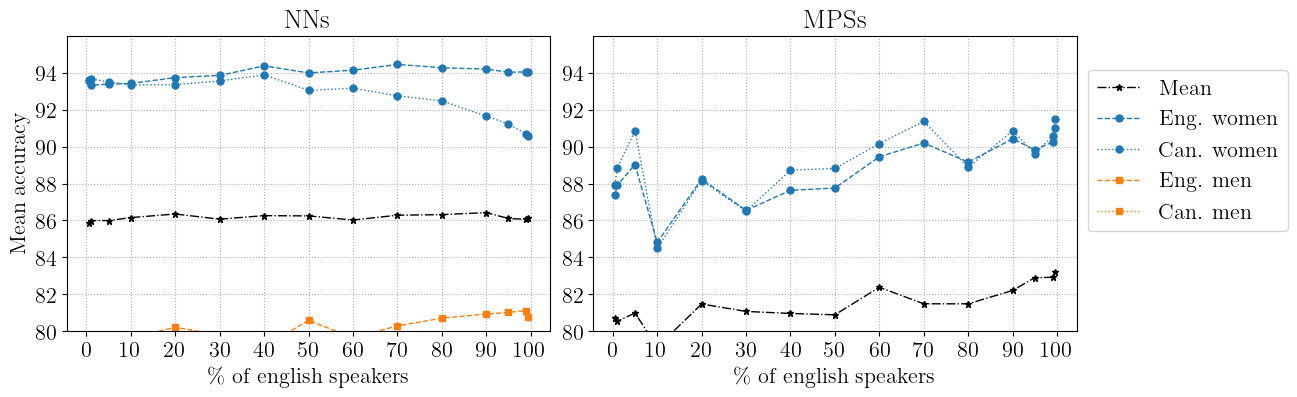

In [25]:
# plt.rc('font', family='serif', size=15)
plt.rc('font', family='serif', serif='Computer Modern', size=16)
plt.rc('text', usetex=True)

colormap = plt.get_cmap("tab10")
colors = ['tab:blue', 'tab:blue', 'tab:orange', 'tab:orange']
markers = ['o', 'o', 's', 's']
linestyles = ['--', ':', '--', ':']
labels = ['Eng. women', 'Can. women', 'Eng. men', 'Can. men']

fig, axs = plt.subplots(1, 2, figsize=(13, 4))
# p_str = [str(p * 100) for p in p_indian_list]
ps = [p * 100 for p in p_indian_list]

# NNs
# ---
means = [100*m for m in mean_nn.values()]

axs[0].plot(ps, means, linestyle='-.', linewidth=1., color='black',
            marker='*', markersize=5., label='Mean')

for i in range(4):
    means = torch.stack(list(map(lambda t: t[0] * 100,
                                 accs_by_comb_nn[i].values()))).tolist()
    stds = torch.stack(list(map(lambda t: t[1] * 100,
                                accs_by_comb_nn[i].values()))).tolist()
    
    # axs[0].errorbar(x=ps, y=means, yerr=stds, capsize=5.,
    #                 linestyle=linestyles[i], linewidth=1., color=colors[i])
    axs[0].plot(ps, means, linestyle=linestyles[i], linewidth=1., color=colors[i],
                marker=markers[i], markersize=5., label=labels[i])

# Set axes
axs[0].set_xlabel('\% of english speakers')
axs[0].set_ylabel('Mean accuracy')

axs[0].set_title('NNs')

axs[0].set_ylim(80, 96)
axs[0].xaxis.grid(linestyle=':')
axs[0].yaxis.grid(linestyle=':')

axs[0].set_xticks(torch.arange(100*0., 100*1.05, 10))
axs[0].set_yticks(torch.arange(100*0.8, 100*0.96, 2))


# MPSs
# ----
means = [100*m for m in mean_mps.values()]

axs[1].plot(ps, means, linestyle='-.', linewidth=1., color='black',
            marker='*', markersize=5., label='Mean')

for i in range(4):
    means = torch.stack(list(map(lambda t: t[0] * 100,
                                 accs_by_comb_mps[i].values()))).tolist()
    stds = torch.stack(list(map(lambda t: t[1] * 100,
                                accs_by_comb_mps[i].values()))).tolist()

    axs[1].plot(ps, means, linestyle=linestyles[i], linewidth=1., color=colors[i],
                marker=markers[i], markersize=5., label=labels[i])

# Set axes
axs[1].set_xlabel('\% of english speakers')
# axs[1].set_ylabel('Mean accuracy')

axs[1].set_title('MPSs')

axs[1].legend(loc='lower left', bbox_to_anchor=(1., 0.3))

axs[1].set_ylim(80, 96)
axs[1].xaxis.grid(linestyle=':')
axs[1].yaxis.grid(linestyle=':')

axs[1].set_xticks(torch.arange(100*0., 100*1.05, 10))
axs[1].set_yticks(torch.arange(100*0.8, 100*0.96, 2))

plt.tight_layout(pad=0.5)

results_dir = os.path.join(cwd, 'results', '6_privacy', 'fffc_tiny', 'attacks')
plt.savefig(os.path.join(results_dir, 'acc_by_class.pdf'), bbox_inches='tight')

plt.show()

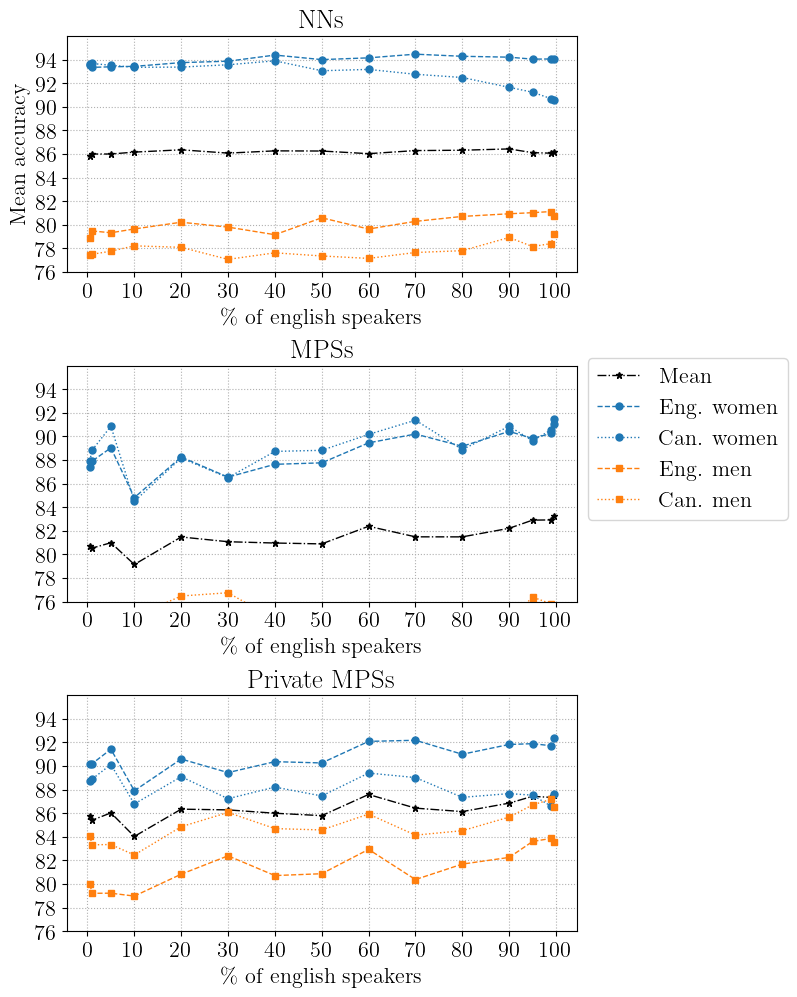

In [29]:
# plt.rc('font', family='serif', size=15)
plt.rc('font', family='serif', serif='Computer Modern', size=16)
plt.rc('text', usetex=True)

colormap = plt.get_cmap("tab10")
colors = ['tab:blue', 'tab:blue', 'tab:orange', 'tab:orange']
markers = ['o', 'o', 's', 's']
linestyles = ['--', ':', '--', ':']
labels = ['Eng. women', 'Can. women', 'Eng. men', 'Can. men']

fig, axs = plt.subplots(3, 1, figsize=(8, 10))
# p_str = [str(p * 100) for p in p_indian_list]
ps = [p * 100 for p in p_indian_list]

# NNs
# ---
means = [100*m for m in mean_nn.values()]

axs[0].plot(ps, means, linestyle='-.', linewidth=1., color='black',
            marker='*', markersize=5., label='Mean')

for i in range(4):
    means = torch.stack(list(map(lambda t: t[0] * 100,
                                 accs_by_comb_nn[i].values()))).tolist()
    stds = torch.stack(list(map(lambda t: t[1] * 100,
                                accs_by_comb_nn[i].values()))).tolist()
    
    # axs[0].errorbar(x=ps, y=means, yerr=stds, capsize=5.,
    #                 linestyle=linestyles[i], linewidth=1., color=colors[i])
    axs[0].plot(ps, means, linestyle=linestyles[i], linewidth=1., color=colors[i],
                marker=markers[i], markersize=5., label=labels[i])

# Set axes
axs[0].set_xlabel('\% of english speakers')
axs[0].set_ylabel('Mean accuracy')

axs[0].set_title('NNs')

axs[0].set_ylim(76, 96)
axs[0].xaxis.grid(linestyle=':')
axs[0].yaxis.grid(linestyle=':')

axs[0].set_xticks(torch.arange(100*0., 100*1.05, 10))
axs[0].set_yticks(torch.arange(100*0.76, 100*0.96, 2))


# MPSs
# ----
means = [100*m for m in mean_mps.values()]

axs[1].plot(ps, means, linestyle='-.', linewidth=1., color='black',
            marker='*', markersize=5., label='Mean')

for i in range(4):
    means = torch.stack(list(map(lambda t: t[0] * 100,
                                 accs_by_comb_mps[i].values()))).tolist()
    stds = torch.stack(list(map(lambda t: t[1] * 100,
                                accs_by_comb_mps[i].values()))).tolist()

    axs[1].plot(ps, means, linestyle=linestyles[i], linewidth=1., color=colors[i],
                marker=markers[i], markersize=5., label=labels[i])

# Set axes
axs[1].set_xlabel('\% of english speakers')
# axs[1].set_ylabel('Mean accuracy')

axs[1].set_title('MPSs')

axs[1].legend(loc='lower left', bbox_to_anchor=(1., 0.3))

axs[1].set_ylim(76, 96)
axs[1].xaxis.grid(linestyle=':')
axs[1].yaxis.grid(linestyle=':')

axs[1].set_xticks(torch.arange(100*0., 100*1.05, 10))
axs[1].set_yticks(torch.arange(100*0.76, 100*0.96, 2))


# Priv MPSs
# ---------
means = [100*m for m in mean_priv_mps.values()]

axs[2].plot(ps, means, linestyle='-.', linewidth=1., color='black',
            marker='*', markersize=5., label='Mean')

for i in range(4):
    means = torch.stack(list(map(lambda t: t[0] * 100,
                                 accs_by_comb_priv_mps[i].values()))).tolist()
    stds = torch.stack(list(map(lambda t: t[1] * 100,
                                accs_by_comb_priv_mps[i].values()))).tolist()

    axs[2].plot(ps, means, linestyle=linestyles[i], linewidth=1., color=colors[i],
                marker=markers[i], markersize=5., label=labels[i])

# Set axes
axs[2].set_xlabel('\% of english speakers')
# axs[1].set_ylabel('Mean accuracy')

axs[2].set_title('Private MPSs')

axs[2].set_ylim(76, 96)
axs[2].xaxis.grid(linestyle=':')
axs[2].yaxis.grid(linestyle=':')

axs[2].set_xticks(torch.arange(100*0., 100*1.05, 10))
axs[2].set_yticks(torch.arange(100*0.76, 100*0.96, 2))

plt.tight_layout(pad=0.5)

results_dir = os.path.join(cwd, 'results', '6_privacy', 'fffc_tiny', 'attacks')
plt.savefig(os.path.join(results_dir, 'acc_by_class.pdf'), bbox_inches='tight')

plt.show()

## NNs

In [5]:
n_samples_dataset = 50
n_samples = 25

assert n_samples < n_samples_dataset

In [26]:
# Create dataset
results_dir = os.path.join(cwd, 'results', '6_privacy',
                           'fffc_tiny', 'attacks', 'nn')

datasets = {}
for p in p_indian_list[:7]:
    # print(p)
    samples = []
    labels = []
    for idx in range(10):
        # print('\t', idx)
        for s in range(25):
            # print('\t\t', s)
            for aux_p in [p, 1 - p]:
                # print('\t\t\t', aux_p)
                model_dir = os.path.join(results_dir, str(aux_p),
                                         str(idx), f'{s}.pt')
                if os.path.exists(model_dir):
                    sample = torch.load(model_dir, weights_only=False)
                    sample.requires_grad = False
                    label = 0 if aux_p < 0.5 else 1
                    
                    sample = torch.cat(
                        [sample[(i*n_samples_dataset):(i*n_samples_dataset + n_samples)]
                         for i in range(4)] + [sample[(4*n_samples_dataset):]],
                        dim=0)
                    
                    samples.append(sample)
                    labels.append(label)
    
    samples = torch.stack(samples, dim=0)
    labels = torch.Tensor(labels)
    
    datasets[p] = (samples, labels)

In [31]:
# Black-box
bb_attack_nn = {}
for p in p_indian_list[:7]:
    train_scores = []
    test_scores = []
    k_folds = 10
    for i in range(k_folds):
        X, y = datasets[p]
        scaler = StandardScaler().fit(X)
        
        max_len = len(y)
        step = max_len // k_folds
        train = torch.cat([torch.arange(0, i * step),
                           torch.arange((i + 1) * step, max_len)], dim=0)
        test = torch.arange(i * step, (i + 1) * step)
        
        
        X_train = X[train]
        scaler = scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        
        y_train = y[train]
        
        
        X_test = X[test]
        scaler = scaler.fit(X_test)
        X_test = scaler.transform(X_test)
        
        y_test = y[test]
        
        
        clf = LogisticRegression(max_iter=1000)
        clf = clf.fit(X_train[:, :(4 * n_samples)], y_train)
        
        train_score = clf.score(X_train[:, :(4 * n_samples)], y_train)
        test_score = clf.score(X_test[:, :(4 * n_samples)], y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    train_scores = torch.Tensor(train_scores)
    test_scores = torch.Tensor(test_scores)
    print(p, train_scores.mean(), test_scores.mean(), test_scores.std())
    
    bb_attack_nn[p] = (test_scores.mean(), test_scores.std())

0.005 tensor(0.9798) tensor(0.9580) tensor(0.0274)
0.01 tensor(0.9760) tensor(0.9580) tensor(0.0239)
0.05 tensor(0.9773) tensor(0.9640) tensor(0.0295)
0.1 tensor(0.9464) tensor(0.9260) tensor(0.0313)
0.2 tensor(0.9471) tensor(0.9060) tensor(0.0508)
0.3 tensor(0.8824) tensor(0.8120) tensor(0.0767)
0.4 tensor(0.7873) tensor(0.7320) tensor(0.0744)


In [32]:
# White-box
wb_attack_nn = {}
for p in p_indian_list[:7]:
    train_scores = []
    test_scores = []
    k_folds = 10
    for i in range(k_folds):
        X, y = datasets[p]
        scaler = StandardScaler().fit(X)
        
        max_len = len(y)
        step = max_len // k_folds
        train = torch.cat([torch.arange(0, i * step),
                           torch.arange((i + 1) * step, max_len)], dim=0)
        test = torch.arange(i * step, (i + 1) * step)
        
        
        X_train = X[train]
        
        X_train_bb = X_train[:, :(4*n_samples)]
        scaler = scaler.fit(X_train_bb)
        X_train_bb = scaler.transform(X_train_bb)
        
        X_train_wb = X_train[:, (4*n_samples):]
        scaler = scaler.fit(X_train_wb)
        X_train_wb = scaler.transform(X_train_wb)
        
        y_train = y[train]
        
        
        X_test = X[test]
        
        X_test_bb = X_test[:, :(4*n_samples)]
        scaler = scaler.fit(X_test_bb)
        X_test_bb = scaler.transform(X_test_bb)
        
        X_test_wb = X_test[:, (4*n_samples):]
        scaler = scaler.fit(X_test_wb)
        X_test_wb = scaler.transform(X_test_wb)
        
        y_test = y[test]
        
        
        clf_bb = LogisticRegression(max_iter=1000)
        clf_bb = clf_bb.fit(X_train_bb[:(step * (k_folds - 1) // 2)],
                            y_train[:(step * (k_folds - 1) // 2)])
        
        clf_wb = LogisticRegression(max_iter=1000)
        clf_wb = clf_wb.fit(X_train_wb[:(step * (k_folds - 1) // 2)],
                            y_train[:(step * (k_folds - 1) // 2)])
        
        
        X_train = torch.stack(
            [torch.Tensor(clf_bb.predict(X_train_bb[(step * (k_folds - 1) // 2):])),
             torch.Tensor(clf_wb.predict(X_train_wb[(step * (k_folds - 1) // 2):]))],
            dim=1)
        X_test = torch.stack(
            [torch.Tensor(clf_bb.predict(X_test_bb)),
             torch.Tensor(clf_wb.predict(X_test_wb))],
            dim=1)
        
        scaler = scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        
        scaler = scaler.fit(X_test)
        X_test = scaler.transform(X_test)
        
        
        clf = LogisticRegression(max_iter=1000)
        clf = clf.fit(X_train, y_train[(step * (k_folds - 1) // 2):])
        
        train_score = clf.score(X_train, y_train[(step * (k_folds - 1) // 2):])
        test_score = clf.score(X_test, y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    train_scores = torch.Tensor(train_scores)
    test_scores = torch.Tensor(test_scores)
    print(p, train_scores.mean(), test_scores.mean(), test_scores.std())
    
    wb_attack_nn[p] = (test_scores.mean(), test_scores.std())

0.005 tensor(0.9991) tensor(0.9960) tensor(0.0084)
0.01 tensor(0.9947) tensor(0.9980) tensor(0.0063)
0.05 tensor(0.9987) tensor(1.) tensor(0.)
0.1 tensor(0.9956) tensor(0.9940) tensor(0.0135)
0.2 tensor(0.9649) tensor(0.9780) tensor(0.0319)
0.3 tensor(0.9196) tensor(0.9020) tensor(0.0437)
0.4 tensor(0.8680) tensor(0.8860) tensor(0.0654)


In [33]:
# Only white-box
owb_attack_nn = {}
for p in p_indian_list[:7]:
    train_scores = []
    test_scores = []
    k_folds = 10
    for i in range(k_folds):
        X, y = datasets[p]
        scaler = StandardScaler().fit(X)
        
        max_len = len(y)
        step = max_len // k_folds
        train = torch.cat([torch.arange(0, i * step),
                           torch.arange((i + 1) * step, max_len)], dim=0)
        test = torch.arange(i * step, (i + 1) * step)
        
        
        X_train = X[train]
        scaler = scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        
        y_train = y[train]
        
        
        X_test = X[test]
        scaler = scaler.fit(X_test)
        X_test = scaler.transform(X_test)
        
        y_test = y[test]
        
        
        clf = LogisticRegression(max_iter=1000)
        clf = clf.fit(X_train[:, (4*n_samples):], y_train)
        
        train_score = clf.score(X_train[:, (4*n_samples):], y_train)
        test_score = clf.score(X_test[:, (4*n_samples):], y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    train_scores = torch.Tensor(train_scores)
    test_scores = torch.Tensor(test_scores)
    print(p, train_scores.mean(), test_scores.mean(), test_scores.std())
    
    owb_attack_nn[p] = (test_scores.mean(), test_scores.std())

0.005 tensor(1.) tensor(0.9980) tensor(0.0063)
0.01 tensor(1.) tensor(0.9980) tensor(0.0063)
0.05 tensor(1.) tensor(1.) tensor(0.)
0.1 tensor(1.) tensor(0.9980) tensor(0.0063)
0.2 tensor(1.) tensor(0.9940) tensor(0.0097)
0.3 tensor(1.) tensor(0.9680) tensor(0.0253)
0.4 tensor(1.) tensor(0.9580) tensor(0.0485)


## MPS

In [34]:
# Create dataset
results_dir = os.path.join(cwd, 'results', '6_privacy',
                           'fffc_tiny', 'attacks', 'cores')

datasets = {}
for p in p_indian_list[:7]:
    samples = []
    labels = []
    for idx in range(10):
        for s in range(25):
            for aux_p in [p, 1 - p]:
                sample = torch.load(
                    os.path.join(results_dir, str(aux_p), str(idx), f'{s}.pt'),
                    weights_only=False
                    )
                sample.requires_grad = False
                label = 0 if aux_p < 0.5 else 1
                
                sample = torch.cat(
                        [sample[(i*n_samples_dataset):(i*n_samples_dataset + n_samples)]
                         for i in range(4)] + [sample[(4*n_samples_dataset):]],
                        dim=0)
                
                samples.append(sample)
                labels.append(label)
    
    min_len = samples[0].size(0)
    for s in samples[1:]:
        if s.size(0) < min_len:
            min_len = s.size(0)
    
    samples = [s[:min_len] for s in samples]
    
    samples = torch.stack(samples, dim=0)
    labels = torch.Tensor(labels)
    
    datasets[p] = (samples, labels)

In [35]:
# Black-box
bb_attack_mps_0_0 = {}
for p in p_indian_list[:7]:
    train_scores = []
    test_scores = []
    k_folds = 10
    for i in range(k_folds):
        X, y = datasets[p]
        scaler = StandardScaler().fit(X)
        
        max_len = len(y)
        step = max_len // k_folds
        train = torch.cat([torch.arange(0, i * step),
                           torch.arange((i + 1) * step, max_len)], dim=0)
        test = torch.arange(i * step, (i + 1) * step)
        
        
        X_train = X[train]
        scaler = scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        
        y_train = y[train]
        
        
        X_test = X[test]
        scaler = scaler.fit(X_test)
        X_test = scaler.transform(X_test)
        
        y_test = y[test]
        
        
        clf = LogisticRegression(max_iter=1000)
        clf = clf.fit(X_train[:, :(4 * n_samples)], y_train)
        
        train_score = clf.score(X_train[:, :(4 * n_samples)], y_train)
        test_score = clf.score(X_test[:, :(4 * n_samples)], y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    train_scores = torch.Tensor(train_scores)
    test_scores = torch.Tensor(test_scores)
    print(p, train_scores.mean(), test_scores.mean(), test_scores.std())
    
    bb_attack_mps_0_0[p] = (test_scores.mean(), test_scores.std())

0.005 tensor(0.8338) tensor(0.7320) tensor(0.0860)
0.01 tensor(0.7962) tensor(0.7080) tensor(0.0329)
0.05 tensor(0.8251) tensor(0.6940) tensor(0.0875)
0.1 tensor(0.8251) tensor(0.7320) tensor(0.0920)
0.2 tensor(0.7436) tensor(0.5360) tensor(0.1142)
0.3 tensor(0.7444) tensor(0.5920) tensor(0.0627)
0.4 tensor(0.7560) tensor(0.6040) tensor(0.0937)


In [36]:
# White-box
wb_attack_mps_0_0 = {}
for p in p_indian_list[:7]:
    train_scores = []
    test_scores = []
    k_folds = 10
    for i in range(k_folds):
        X, y = datasets[p]
        scaler = StandardScaler().fit(X)
        
        max_len = len(y)
        step = max_len // k_folds
        train = torch.cat([torch.arange(0, i * step),
                           torch.arange((i + 1) * step, max_len)], dim=0)
        test = torch.arange(i * step, (i + 1) * step)
        
        
        X_train = X[train]
        
        X_train_bb = X_train[:, :(4*n_samples)]
        scaler = scaler.fit(X_train_bb)
        X_train_bb = scaler.transform(X_train_bb)
        
        X_train_wb = X_train[:, (4*n_samples):]
        scaler = scaler.fit(X_train_wb)
        X_train_wb = scaler.transform(X_train_wb)
        
        y_train = y[train]
        
        
        X_test = X[test]
        
        X_test_bb = X_test[:, :(4*n_samples)]
        scaler = scaler.fit(X_test_bb)
        X_test_bb = scaler.transform(X_test_bb)
        
        X_test_wb = X_test[:, (4*n_samples):]
        scaler = scaler.fit(X_test_wb)
        X_test_wb = scaler.transform(X_test_wb)
        
        y_test = y[test]
        
        
        clf_bb = LogisticRegression(max_iter=1000)
        clf_bb = clf_bb.fit(X_train_bb[:(step * (k_folds - 1) // 2)],
                            y_train[:(step * (k_folds - 1) // 2)])
        
        clf_wb = LogisticRegression(max_iter=1000)
        clf_wb = clf_wb.fit(X_train_wb[:(step * (k_folds - 1) // 2)],
                            y_train[:(step * (k_folds - 1) // 2)])
        
        
        X_train = torch.stack(
            [torch.Tensor(clf_bb.predict(X_train_bb[(step * (k_folds - 1) // 2):])),
             torch.Tensor(clf_wb.predict(X_train_wb[(step * (k_folds - 1) // 2):]))],
            dim=1)
        X_test = torch.stack(
            [torch.Tensor(clf_bb.predict(X_test_bb)),
             torch.Tensor(clf_wb.predict(X_test_wb))],
            dim=1)
        
        scaler = scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        
        scaler = scaler.fit(X_test)
        X_test = scaler.transform(X_test)
        
        
        clf = LogisticRegression(max_iter=1000)
        clf = clf.fit(X_train, y_train[(step * (k_folds - 1) // 2):])
        
        train_score = clf.score(X_train, y_train[(step * (k_folds - 1) // 2):])
        test_score = clf.score(X_test, y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    train_scores = torch.Tensor(train_scores)
    test_scores = torch.Tensor(test_scores)
    print(p, train_scores.mean(), test_scores.mean(), test_scores.std())
    
    wb_attack_mps_0_0[p] = (test_scores.mean(), test_scores.std())

0.005 tensor(0.6756) tensor(0.7160) tensor(0.0878)
0.01 tensor(0.7067) tensor(0.6860) tensor(0.0633)
0.05 tensor(0.6596) tensor(0.6780) tensor(0.0926)
0.1 tensor(0.7089) tensor(0.6860) tensor(0.0542)
0.2 tensor(0.5796) tensor(0.5720) tensor(0.0454)
0.3 tensor(0.6111) tensor(0.5960) tensor(0.0645)
0.4 tensor(0.6093) tensor(0.5400) tensor(0.0957)


In [37]:
# Only white-box
owb_attack_mps_0_0 = {}
for p in p_indian_list[:7]:
    train_scores = []
    test_scores = []
    k_folds = 10
    for i in range(k_folds):
        X, y = datasets[p]
        scaler = StandardScaler().fit(X)
        
        max_len = len(y)
        step = max_len // k_folds
        train = torch.cat([torch.arange(0, i * step),
                           torch.arange((i + 1) * step, max_len)], dim=0)
        test = torch.arange(i * step, (i + 1) * step)
        
        
        X_train = X[train]
        scaler = scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        
        y_train = y[train]
        
        
        X_test = X[test]
        scaler = scaler.fit(X_test)
        X_test = scaler.transform(X_test)
        
        y_test = y[test]
        
        
        clf = LogisticRegression(max_iter=1000)
        clf = clf.fit(X_train[:, (4*n_samples):], y_train)
        
        train_score = clf.score(X_train[:, (4*n_samples):], y_train)
        test_score = clf.score(X_test[:, (4*n_samples):], y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    train_scores = torch.Tensor(train_scores)
    test_scores = torch.Tensor(test_scores)
    print(p, train_scores.mean(), test_scores.mean(), test_scores.std())
    
    owb_attack_mps_0_0[p] = (test_scores.mean(), test_scores.std())

0.005 tensor(1.) tensor(0.6820) tensor(0.0739)
0.01 tensor(1.) tensor(0.6600) tensor(0.1033)
0.05 tensor(1.) tensor(0.6840) tensor(0.0765)
0.1 tensor(1.) tensor(0.6740) tensor(0.0626)
0.2 tensor(1.) tensor(0.5860) tensor(0.0574)
0.3 tensor(1.) tensor(0.5960) tensor(0.0888)
0.4 tensor(1.) tensor(0.6020) tensor(0.0813)


## Re-trained MPS

In [49]:
# Create dataset
results_dir = os.path.join(cwd, 'results', '6_privacy',
                           'fffc_tiny', 'attacks', 'recores')

datasets = {}
for p in p_indian_list[:7]:
    samples = []
    labels = []
    for idx in range(10):
        for s in range(25):
            for aux_p in [p, 1 - p]:
                sample = torch.load(
                    os.path.join(results_dir, str(aux_p), str(idx), f'{s}.pt'),
                    weights_only=False
                    )
                sample.requires_grad = False
                label = 0 if aux_p < 0.5 else 1
                
                sample = torch.cat(
                        [sample[(i*n_samples_dataset):(i*n_samples_dataset + n_samples)]
                         for i in range(4)] + [sample[(4*n_samples_dataset):]],
                        dim=0)
                
                samples.append(sample)
                labels.append(label)
    
    min_len = samples[0].size(0)
    for s in samples[1:]:
        if s.size(0) < min_len:
            min_len = s.size(0)
    
    samples = [s[:min_len] for s in samples]
    
    samples = torch.stack(samples, dim=0)
    labels = torch.Tensor(labels)
    
    datasets[p] = (samples, labels)

In [50]:
# Black-box
bb_attack_mps_1_0 = {}
for p in p_indian_list[:7]:
    train_scores = []
    test_scores = []
    k_folds = 10
    for i in range(k_folds):
        X, y = datasets[p]
        X, y = X[~X.isnan().any(dim=1)], y[~X.isnan().any(dim=1)]
        scaler = StandardScaler().fit(X)
        
        max_len = len(y)
        step = max_len // k_folds
        train = torch.cat([torch.arange(0, i * step),
                           torch.arange((i + 1) * step, max_len)], dim=0)
        test = torch.arange(i * step, (i + 1) * step)
        
        
        X_train = X[train]
        scaler = scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        
        y_train = y[train]
        
        
        X_test = X[test]
        scaler = scaler.fit(X_test)
        X_test = scaler.transform(X_test)
        
        y_test = y[test]
        
        
        clf = LogisticRegression(max_iter=1000)
        clf = clf.fit(X_train[:, :(4 * n_samples)], y_train)
        
        train_score = clf.score(X_train[:, :(4 * n_samples)], y_train)
        test_score = clf.score(X_test[:, :(4 * n_samples)], y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    train_scores = torch.Tensor(train_scores)
    test_scores = torch.Tensor(test_scores)
    print(p, train_scores.mean(), test_scores.mean(), test_scores.std())
    
    bb_attack_mps_1_0[p] = (test_scores.mean(), test_scores.std())

0.005 tensor(0.8100) tensor(0.7440) tensor(0.0826)
0.01 tensor(0.7729) tensor(0.7360) tensor(0.0556)
0.05 tensor(0.7871) tensor(0.7140) tensor(0.0900)
0.1 tensor(0.7958) tensor(0.7280) tensor(0.0865)
0.2 tensor(0.7140) tensor(0.6327) tensor(0.0839)
0.3 tensor(0.6678) tensor(0.5680) tensor(0.0575)
0.4 tensor(0.6911) tensor(0.6100) tensor(0.0834)


In [51]:
# White-box
wb_attack_mps_1_0 = {}
for p in p_indian_list[:7]:
    train_scores = []
    test_scores = []
    k_folds = 10
    for i in range(k_folds):
        X, y = datasets[p]
        X, y = X[~X.isnan().any(dim=1)], y[~X.isnan().any(dim=1)]
        scaler = StandardScaler().fit(X)
        
        max_len = len(y)
        step = max_len // k_folds
        train = torch.cat([torch.arange(0, i * step),
                           torch.arange((i + 1) * step, max_len)], dim=0)
        test = torch.arange(i * step, (i + 1) * step)
        
        
        X_train = X[train]
        
        X_train_bb = X_train[:, :(4*n_samples)]
        scaler = scaler.fit(X_train_bb)
        X_train_bb = scaler.transform(X_train_bb)
        
        X_train_wb = X_train[:, (4*n_samples):]
        scaler = scaler.fit(X_train_wb)
        X_train_wb = scaler.transform(X_train_wb)
        
        y_train = y[train]
        
        
        X_test = X[test]
        
        X_test_bb = X_test[:, :(4*n_samples)]
        scaler = scaler.fit(X_test_bb)
        X_test_bb = scaler.transform(X_test_bb)
        
        X_test_wb = X_test[:, (4*n_samples):]
        scaler = scaler.fit(X_test_wb)
        X_test_wb = scaler.transform(X_test_wb)
        
        y_test = y[test]
        
        
        clf_bb = LogisticRegression(max_iter=1000)
        clf_bb = clf_bb.fit(X_train_bb[:(step * (k_folds - 1) // 2)],
                            y_train[:(step * (k_folds - 1) // 2)])
        
        clf_wb = LogisticRegression(max_iter=1000)
        clf_wb = clf_wb.fit(X_train_wb[:(step * (k_folds - 1) // 2)],
                            y_train[:(step * (k_folds - 1) // 2)])
        
        
        X_train = torch.stack(
            [torch.Tensor(clf_bb.predict(X_train_bb[(step * (k_folds - 1) // 2):])),
             torch.Tensor(clf_wb.predict(X_train_wb[(step * (k_folds - 1) // 2):]))],
            dim=1)
        X_test = torch.stack(
            [torch.Tensor(clf_bb.predict(X_test_bb)),
             torch.Tensor(clf_wb.predict(X_test_wb))],
            dim=1)
        
        scaler = scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        
        scaler = scaler.fit(X_test)
        X_test = scaler.transform(X_test)
        
        
        clf = LogisticRegression(max_iter=1000)
        clf = clf.fit(X_train, y_train[(step * (k_folds - 1) // 2):])
        
        train_score = clf.score(X_train, y_train[(step * (k_folds - 1) // 2):])
        test_score = clf.score(X_test, y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    train_scores = torch.Tensor(train_scores)
    test_scores = torch.Tensor(test_scores)
    print(p, train_scores.mean(), test_scores.mean(), test_scores.std())
    
    wb_attack_mps_1_0[p] = (test_scores.mean(), test_scores.std())

0.005 tensor(0.7182) tensor(0.7200) tensor(0.0581)
0.01 tensor(0.7373) tensor(0.7240) tensor(0.0704)
0.05 tensor(0.7107) tensor(0.6740) tensor(0.0880)
0.1 tensor(0.7111) tensor(0.7000) tensor(0.0712)
0.2 tensor(0.6017) tensor(0.5694) tensor(0.0339)
0.3 tensor(0.6116) tensor(0.5940) tensor(0.0534)
0.4 tensor(0.6013) tensor(0.5540) tensor(0.0760)


In [52]:
# Only white-box
owb_attack_mps_1_0 = {}
for p in p_indian_list[:7]:
    train_scores = []
    test_scores = []
    k_folds = 10
    for i in range(k_folds):
        X, y = datasets[p]
        X, y = X[~X.isnan().any(dim=1)], y[~X.isnan().any(dim=1)]
        scaler = StandardScaler().fit(X)
        
        max_len = len(y)
        step = max_len // k_folds
        train = torch.cat([torch.arange(0, i * step),
                           torch.arange((i + 1) * step, max_len)], dim=0)
        test = torch.arange(i * step, (i + 1) * step)
        
        
        X_train = X[train]
        scaler = scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        
        y_train = y[train]
        
        
        X_test = X[test]
        scaler = scaler.fit(X_test)
        X_test = scaler.transform(X_test)
        
        y_test = y[test]
        
        
        clf = LogisticRegression(max_iter=1000)
        clf = clf.fit(X_train[:, (4*n_samples):], y_train)
        
        train_score = clf.score(X_train[:, (4*n_samples):], y_train)
        test_score = clf.score(X_test[:, (4*n_samples):], y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    train_scores = torch.Tensor(train_scores)
    test_scores = torch.Tensor(test_scores)
    print(p, train_scores.mean(), test_scores.mean(), test_scores.std())
    
    owb_attack_mps_1_0[p] = (test_scores.mean(), test_scores.std())

0.005 tensor(1.) tensor(0.6820) tensor(0.0739)
0.01 tensor(1.) tensor(0.6600) tensor(0.1033)
0.05 tensor(1.) tensor(0.6820) tensor(0.0745)
0.1 tensor(1.) tensor(0.6740) tensor(0.0626)
0.2 tensor(1.) tensor(0.6020) tensor(0.0502)
0.3 tensor(1.) tensor(0.5960) tensor(0.0888)
0.4 tensor(1.) tensor(0.6020) tensor(0.0813)


## Re-trained private MPS

In [6]:
# Create dataset
results_dir = os.path.join(cwd, 'results', '6_privacy',
                           'fffc_tiny', 'attacks', 'priv_recores')

datasets = {}
for p in p_indian_list[:7]:
    samples = []
    labels = []
    for idx in range(10):
        for s in range(25):
            for aux_p in [p, 1 - p]:
                sample = torch.load(
                    os.path.join(results_dir, str(aux_p), str(idx), f'{s}.pt'),
                    weights_only=False
                    )
                sample.requires_grad = False
                label = 0 if aux_p < 0.5 else 1
                
                sample = torch.cat(
                        [sample[(i*n_samples_dataset):(i*n_samples_dataset + n_samples)]
                         for i in range(4)] + [sample[(4*n_samples_dataset):]],
                        dim=0)
                
                samples.append(sample)
                labels.append(label)
    
    min_len = samples[0].size(0)
    for s in samples[1:]:
        if s.size(0) < min_len:
            min_len = s.size(0)
    
    samples = [s[:min_len] for s in samples]
    
    samples = torch.stack(samples, dim=0)
    labels = torch.Tensor(labels)
    
    datasets[p] = (samples, labels)

In [7]:
# Black-box
bb_attack_mps_1_1 = {}
for p in p_indian_list[:7]:
    train_scores = []
    test_scores = []
    k_folds = 10
    for i in range(k_folds):
        X, y = datasets[p]
        X, y = X[~X.isnan().any(dim=1)], y[~X.isnan().any(dim=1)]
        scaler = StandardScaler().fit(X)
        
        max_len = len(y)
        step = max_len // k_folds
        train = torch.cat([torch.arange(0, i * step),
                           torch.arange((i + 1) * step, max_len)], dim=0)
        test = torch.arange(i * step, (i + 1) * step)
        
        
        X_train = X[train]
        scaler = scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        
        y_train = y[train]
        
        
        X_test = X[test]
        scaler = scaler.fit(X_test)
        X_test = scaler.transform(X_test)
        
        y_test = y[test]
        
        
        clf = LogisticRegression(max_iter=1000)
        clf = clf.fit(X_train[:, :(4 * n_samples)], y_train)
        
        train_score = clf.score(X_train[:, :(4 * n_samples)], y_train)
        test_score = clf.score(X_test[:, :(4 * n_samples)], y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    train_scores = torch.Tensor(train_scores)
    test_scores = torch.Tensor(test_scores)
    print(p, train_scores.mean(), test_scores.mean(), test_scores.std())
    
    bb_attack_mps_1_1[p] = (test_scores.mean(), test_scores.std())

0.005 tensor(0.8124) tensor(0.7440) tensor(0.0903)
0.01 tensor(0.7764) tensor(0.7380) tensor(0.0702)
0.05 tensor(0.7958) tensor(0.7260) tensor(0.0952)
0.1 tensor(0.7944) tensor(0.7240) tensor(0.0729)
0.2 tensor(0.7100) tensor(0.6265) tensor(0.0822)
0.3 tensor(0.6782) tensor(0.5660) tensor(0.0542)
0.4 tensor(0.6898) tensor(0.6000) tensor(0.1033)


In [8]:
# White-box
wb_attack_mps_1_1 = {}
for p in p_indian_list[:7]:
    train_scores = []
    test_scores = []
    k_folds = 10
    for i in range(k_folds):
        X, y = datasets[p]
        X, y = X[~X.isnan().any(dim=1)], y[~X.isnan().any(dim=1)]
        scaler = StandardScaler().fit(X)
        
        max_len = len(y)
        step = max_len // k_folds
        train = torch.cat([torch.arange(0, i * step),
                           torch.arange((i + 1) * step, max_len)], dim=0)
        test = torch.arange(i * step, (i + 1) * step)
        
        
        X_train = X[train]
        
        X_train_bb = X_train[:, :(4*n_samples)]
        scaler = scaler.fit(X_train_bb)
        X_train_bb = scaler.transform(X_train_bb)
        
        X_train_wb = X_train[:, (4*n_samples):]
        scaler = scaler.fit(X_train_wb)
        X_train_wb = scaler.transform(X_train_wb)
        
        y_train = y[train]
        
        
        X_test = X[test]
        
        X_test_bb = X_test[:, :(4*n_samples)]
        scaler = scaler.fit(X_test_bb)
        X_test_bb = scaler.transform(X_test_bb)
        
        X_test_wb = X_test[:, (4*n_samples):]
        scaler = scaler.fit(X_test_wb)
        X_test_wb = scaler.transform(X_test_wb)
        
        y_test = y[test]
        
        
        clf_bb = LogisticRegression(max_iter=1000)
        clf_bb = clf_bb.fit(X_train_bb[:(step * (k_folds - 1) // 2)],
                            y_train[:(step * (k_folds - 1) // 2)])
        
        clf_wb = LogisticRegression(max_iter=1000)
        clf_wb = clf_wb.fit(X_train_wb[:(step * (k_folds - 1) // 2)],
                            y_train[:(step * (k_folds - 1) // 2)])
        
        
        X_train = torch.stack(
            [torch.Tensor(clf_bb.predict(X_train_bb[(step * (k_folds - 1) // 2):])),
             torch.Tensor(clf_wb.predict(X_train_wb[(step * (k_folds - 1) // 2):]))],
            dim=1)
        X_test = torch.stack(
            [torch.Tensor(clf_bb.predict(X_test_bb)),
             torch.Tensor(clf_wb.predict(X_test_wb))],
            dim=1)
        
        scaler = scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        
        scaler = scaler.fit(X_test)
        X_test = scaler.transform(X_test)
        
        
        clf = LogisticRegression(max_iter=1000)
        clf = clf.fit(X_train, y_train[(step * (k_folds - 1) // 2):])
        
        train_score = clf.score(X_train, y_train[(step * (k_folds - 1) // 2):])
        test_score = clf.score(X_test, y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    train_scores = torch.Tensor(train_scores)
    test_scores = torch.Tensor(test_scores)
    print(p, train_scores.mean(), test_scores.mean(), test_scores.std())
    
    wb_attack_mps_1_1[p] = (test_scores.mean(), test_scores.std())

0.005 tensor(0.7284) tensor(0.7180) tensor(0.0636)
0.01 tensor(0.7276) tensor(0.7380) tensor(0.0774)
0.05 tensor(0.7018) tensor(0.6880) tensor(0.1029)
0.1 tensor(0.7107) tensor(0.7080) tensor(0.0725)
0.2 tensor(0.5626) tensor(0.5816) tensor(0.0759)
0.3 tensor(0.6027) tensor(0.5380) tensor(0.0600)
0.4 tensor(0.5853) tensor(0.6200) tensor(0.0879)


In [9]:
# Only white-box
owb_attack_mps_1_1 = {}
for p in p_indian_list[:7]:
    train_scores = []
    test_scores = []
    k_folds = 10
    for i in range(k_folds):
        X, y = datasets[p]
        X, y = X[~X.isnan().any(dim=1)], y[~X.isnan().any(dim=1)]
        scaler = StandardScaler().fit(X)
        
        max_len = len(y)
        step = max_len // k_folds
        train = torch.cat([torch.arange(0, i * step),
                           torch.arange((i + 1) * step, max_len)], dim=0)
        test = torch.arange(i * step, (i + 1) * step)
        
        
        X_train = X[train]
        scaler = scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        
        y_train = y[train]
        
        
        X_test = X[test]
        scaler = scaler.fit(X_test)
        X_test = scaler.transform(X_test)
        
        y_test = y[test]
        
        
        clf = LogisticRegression(max_iter=1000)
        clf = clf.fit(X_train[:, (4*n_samples):], y_train)
        
        train_score = clf.score(X_train[:, (4*n_samples):], y_train)
        test_score = clf.score(X_test[:, (4*n_samples):], y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    train_scores = torch.Tensor(train_scores)
    test_scores = torch.Tensor(test_scores)
    print(p, train_scores.mean(), test_scores.mean(), test_scores.std())
    
    owb_attack_mps_1_1[p] = (test_scores.mean(), test_scores.std())

0.005 tensor(1.) tensor(0.5300) tensor(0.0756)
0.01 tensor(1.) tensor(0.5680) tensor(0.0925)
0.05 tensor(1.) tensor(0.4860) tensor(0.0525)
0.1 tensor(1.) tensor(0.4660) tensor(0.0924)
0.2 tensor(1.) tensor(0.4714) tensor(0.0690)
0.3 tensor(1.) tensor(0.5220) tensor(0.0629)
0.4 tensor(1.) tensor(0.5220) tensor(0.0512)


## Figure

In [ ]:
results_dir = os.path.join(cwd, 'results', '6_privacy',
                           'fffc_tiny', 'attacks')

bb_attacks = [bb_attack_nn,
              bb_attack_mps_0_0,
              bb_attack_mps_1_0,
              bb_attack_mps_1_1]
wb_attacks = [wb_attack_nn,
              wb_attack_mps_0_0,
              wb_attack_mps_1_0,
              wb_attack_mps_1_1]
owb_attacks = [owb_attack_nn,
               owb_attack_mps_0_0,
               owb_attack_mps_1_0,
               owb_attack_mps_1_1]

# torch.save(bb_attacks, os.path.join(results_dir, 'bb_attacks.pt'))
# torch.save(wb_attacks, os.path.join(results_dir, 'wb_attacks.pt'))
# torch.save(owb_attacks, os.path.join(results_dir, 'owb_attacks.pt'))

In [12]:
results_dir = os.path.join(cwd, 'results', '6_privacy',
                           'fffc_tiny', 'attacks')

bb_attacks = torch.load(os.path.join(results_dir, 'bb_attacks.pt'),
                        weights_only=False)
wb_attacks = torch.load(os.path.join(results_dir, 'wb_attacks.pt'),
                        weights_only=False)
owb_attacks = torch.load(os.path.join(results_dir, 'owb_attacks.pt'),
                         weights_only=False)

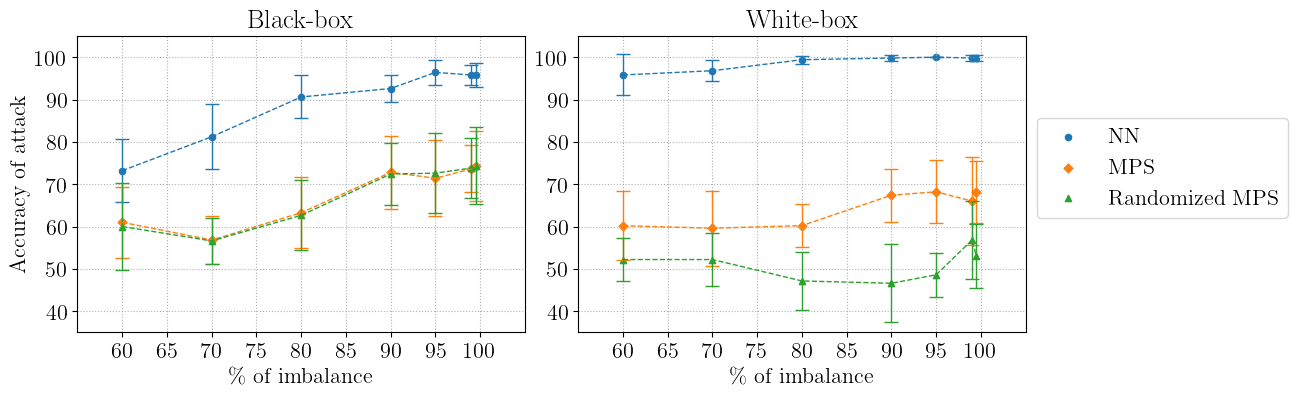

In [14]:
# plt.rc('font', family='serif', size=15)
plt.rc('font', family='serif', serif='Computer Modern', size=16)
plt.rc('text', usetex=True)

colormap = plt.get_cmap("tab10")
colors = ['tab:blue', 'tab:orange', 'tab:orange', 'tab:green']
markers = ['o', 's', 'D', '^']
labels = ['NN', 'MPS', 'MPS', 'Randomized MPS']

fig, axs = plt.subplots(1, 2, figsize=(13, 4))

p_indian_list = [0.005, 0.01, 0.05,
                 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                 0.95, 0.99, 0.995]
ps = [100*(1-p) for p in p_indian_list[:7]]
ps.reverse()


# BB
# --
for i in [0, 2, 3]:
    means = torch.stack(list(map(lambda t: t[0] * 100,
                                 bb_attacks[i].values()))).tolist()
    stds = torch.stack(list(map(lambda t: t[1] * 100,
                                bb_attacks[i].values()))).tolist()
    
    means.reverse()
    stds.reverse()

    axs[0].errorbar(x=ps, y=means, yerr=stds, capsize=5.,
                    linestyle='--', linewidth=1., color=colors[i])
    axs[0].scatter(x=ps, y=means, marker=markers[i], s=20., color=colors[i])

    # Set axes
    axs[0].set_xlabel('\% of imbalance')
    axs[0].set_ylabel('Accuracy of attack')
    axs[0].set_title('Black-box')

    axs[0].yaxis.grid(linestyle=':')
    axs[0].xaxis.grid(linestyle=':')

    axs[0].set_xlim(55, 105)
    axs[0].set_ylim(35, 105)

    axs[0].set_xticks(torch.arange(100*0.6, 100*1.03, 5))
    axs[0].set_yticks(torch.arange(100*0.4, 100*1.05, 10))

# OWB
# ---
for i in [0, 2, 3]:
    means = torch.stack(list(map(lambda t: t[0] * 100,
                                 owb_attacks[i].values()))).tolist()
    stds = torch.stack(list(map(lambda t: t[1] * 100,
                                owb_attacks[i].values()))).tolist()
    
    means.reverse()
    stds.reverse()

    axs[1].errorbar(x=ps, y=means, yerr=stds, capsize=5.,
                    linestyle='--', linewidth=1., color=colors[i])
    axs[1].scatter(x=ps, y=means, marker=markers[i], s=20., color=colors[i],
                   label=labels[i])

    # Set axes
    axs[1].set_xlabel('\% of imbalance')
    axs[1].set_title('White-box')

    axs[1].yaxis.grid(linestyle=':')
    axs[1].xaxis.grid(linestyle=':')
    
    axs[1].set_xlim(55, 105)
    axs[1].set_ylim(35, 105)

    axs[1].set_xticks(torch.arange(100*0.6, 100*1.03, 5))
    axs[1].set_yticks(torch.arange(100*0.4, 100*1.05, 10))
    
    axs[1].legend(loc='lower left', bbox_to_anchor=(1., 0.35))


plt.tight_layout(pad=0.5)

results_dir = os.path.join(cwd, 'results', '6_privacy', 'fffc_tiny', 'attacks')
plt.savefig(os.path.join(results_dir, 'attacks.pdf'), bbox_inches='tight')

plt.show()